In [27]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [28]:
#Base cofficients (now: random!)
BASE_WEIGHTS = {
    'age': 0.2,
    'income': 0.15,
    'openness': 0.1,
    'conscientiousness': 0.1,
    'extraversion': 0.1,
    'agreeableness': 0.1,
    'neuroticism': 0.1,
    'depressed_mood': 0.05,
    'anhedonia': 0.05,
    'weight_change': 0.05,
    'sleep_disturbance': 0.05,
    'psychomotor': 0.05,
    'fatigue': 0.05,
    'worthlessness': 0.05,
    'concentration': 0.05,
    'suicidal_ideation': 0.05,
    'total_depressive_symptoms': 0.05,
    'education': 0.1,
    'ethnicity': 0.1,
    'gender': 0.1,
    'religion': 0.1
}

MAX_HOURS = 39

Set-up

In [29]:
seed = 123
n = 8 #support group size
data = pd.read_csv('synthetic_correlated_data.csv')
support_group_data = data.sample(n=n, random_state=seed).reset_index(drop=True)
print(support_group_data)

   age  income  gender              ethnicity            religion education  \
0   34    4484    Male                  Dutch  Other religion(-s)       VWO   
1   36    9182    Male                  Dutch                None       MBO   
2   38    3715   Other  Other ethnicity(-ies)              Muslim   Primary   
3   30    4699  Female                  Dutch                None      VMBO   
4   31    1231    Male                  Dutch                None       MBO   
5   36    2511  Female                  Dutch          Protestant      VMBO   
6   59    8959  Female                  Dutch                None       MBO   
7   44    4887    Male  Other ethnicity(-ies)      Roman Catholic        WO   

   openness  conscientiousness  extraversion  agreeableness  ...  \
0  3.020016           2.896947      3.174045       3.549335  ...   
1  3.906410           2.983600      2.520006       3.153595  ...   
2  3.824393           3.658948      3.152840       3.035394  ...   
3  3.981346     

Create a graph

In [30]:
G = nx.complete_graph(n)

for i, row in support_group_data.iterrows():
     G.add_node(i, **row.to_dict())

Define the homophily function

In [31]:
def homophily_function(node1, node2, G, weights, max_hours):
    '''Homophily function for edge prediction
    The output should be the number of hours the two people in the edge spend together'''

    distance = 0

    for attribute, weight in weights.items():
        value1 = G.nodes[node1].get(attribute)
        value2 = G.nodes[node2].get(attribute)

        #handle continuous variables
        if isinstance(value1, (int, float)) and isinstance(value2, (int, float)): #TODO: add handling o NA values
            distance += weight * abs(value1 - value2) #TODO:square here is euclidean distance

        #handle categorical variables
        elif isinstance(value1, str) and isinstance(value2, str):
            if value1 != value2:
                distance += weight 

    #TODO:sqrt distance here if euclidean

    #Convert distance to hours
    #TODO: use a nonmonotonic function here according to Bruggeman
    hours = max_hours - distance # when nodes are identical, they spend max hours
    hours = round(hours, 2) # hours = round(max(0, hours), 2)
    return hours

Assign weights based on the homophily function

In [32]:
for node1, node2 in G.edges():
    weight = homophily_function(node1, node2, G, BASE_WEIGHTS, MAX_HOURS)
    G.edges[node1, node2]['weight'] = weight

Display graph

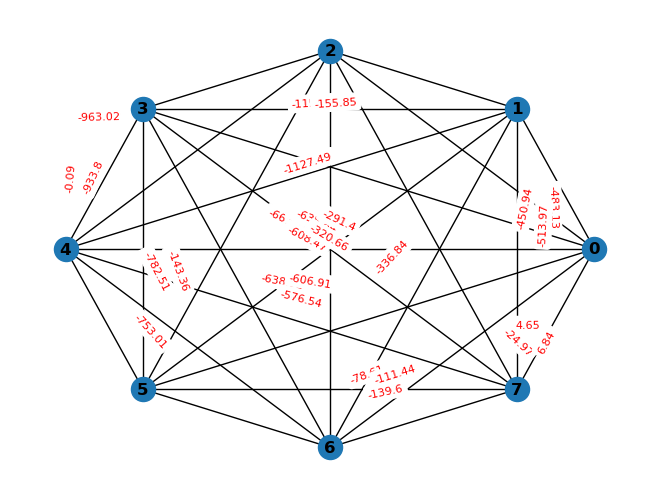

In [33]:
pos=nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=edge_labels, font_size=8, font_color='red');


Linear regression to extract coefficients

In [34]:
#data prep

def prepare_regression_data(G, attributes, max_hours):
    '''Prepares data for regression'''
    data = []

    for node1, node2, edge in G.edges(data=True):
        row = {}

        for attr in attributes:
            value1 = G.nodes[node1].get(attr, 0)
            value2 = G.nodes[node2].get(attr, 0)

            # Absolute differences for continuous attributes
            if isinstance(value1, (int, float)) and isinstance(value2, (int, float)):
                row[attr] = - abs(value1 - value2) #minus because distance has negative contribution to hours
            
            # Binary differences for categorical attributes
            elif isinstance(value1, str) and isinstance(value2, str):
                row[attr] = - 1 if value1 != value2 else 0 #minus because distance has negative contribution to hours
                
        row['target'] = edge['weight']
        data.append(row)      

    return pd.DataFrame(data)

Regression

In [35]:
attributes = list(support_group_data.columns.values)
regression_data = prepare_regression_data(G, attributes, MAX_HOURS)

X = regression_data[attributes]
Y = regression_data['target']

#fit
model = LinearRegression()
model.fit(X, Y)

recovered_weights = round(pd.Series(model.coef_, index=attributes), 2)


Comparison

In [36]:
# Combine into a DataFrame for comparison
comparison = pd.DataFrame({
    'Base Weights': BASE_WEIGHTS,
    'Recovered Weights': recovered_weights
})

# Display the comparison
print(comparison)

                           Base Weights  Recovered Weights
age                                0.20               0.20
agreeableness                      0.10               0.10
anhedonia                          0.05               0.05
concentration                      0.05               0.05
conscientiousness                  0.10               0.10
depressed_mood                     0.05               0.05
education                          0.10               0.10
ethnicity                          0.10               0.10
extraversion                       0.10               0.10
fatigue                            0.05               0.04
gender                             0.10               0.10
income                             0.15               0.15
neuroticism                        0.10               0.10
openness                           0.10               0.10
psychomotor                        0.05               0.05
religion                           0.10               0.

Regenerate a graph with recovered weights

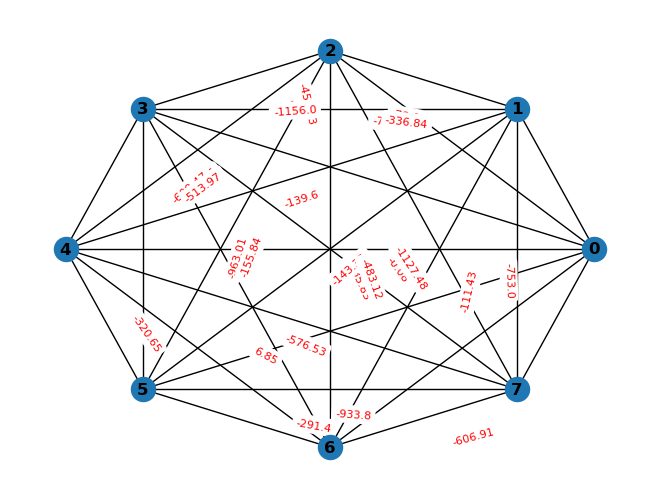

In [37]:
G_recovered = nx.complete_graph(n)

#assign attributes to the recovered graph (same as in the original graph)
for i, row in support_group_data.iterrows():
     G.add_node(i, **row.to_dict())

#assign weights based on homophily function
for node1, node2 in G_recovered.edges():
    weight = homophily_function(node1, node2, G, recovered_weights, MAX_HOURS)
    G_recovered.edges[node1, node2]['weight'] = weight

#display graph
pos=nx.circular_layout(G_recovered)
nx.draw(G_recovered, pos, with_labels=True, font_weight='bold')
edge_labels = nx.get_edge_attributes(G_recovered, 'weight')
nx.draw_networkx_edge_labels(G_recovered, pos=nx.spring_layout(G_recovered), edge_labels=edge_labels, font_size=8, font_color='red');

Compare original network with recovered

In [38]:
nx.graph_edit_distance(G, G_recovered)

0.0

In [39]:
nx.is_isomorphic(G, G_recovered)

True